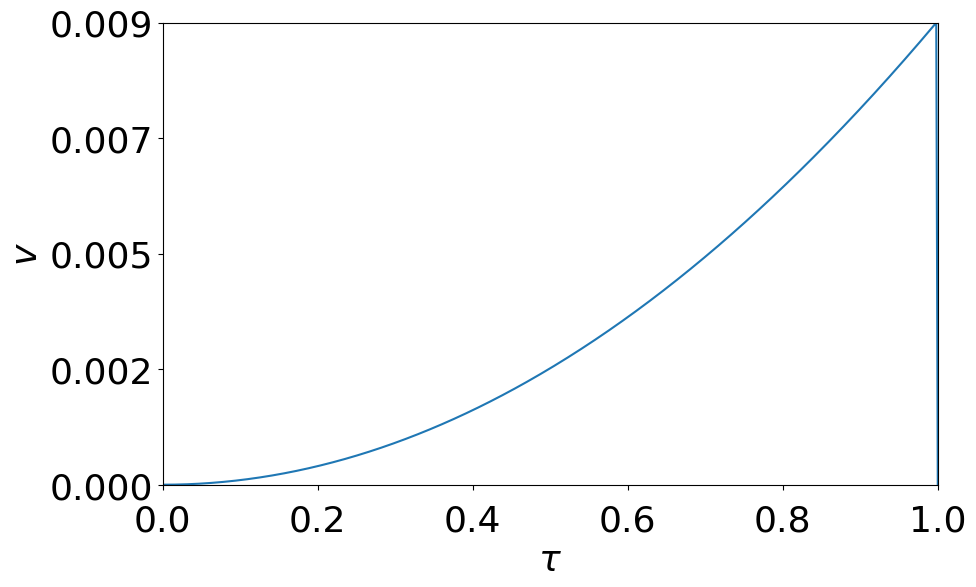

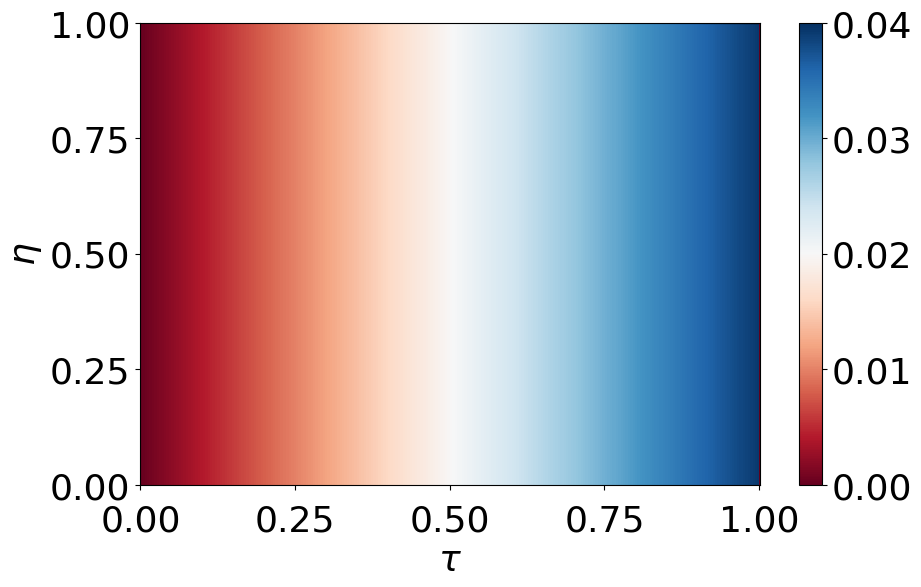

Numero de Richardson: 2.58e+02 
Numero de Rayleigh: 2.23e+06 
phi: 5.4496 
Lambda: 5.00 
v_e: 4.00


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]

# Parametros directos
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R # Diametro de la tubería [m]
Delta_T = 50 # diferencia de temperaturas [K]

# Definicion de parametros indirectos
def parametros(D, L, Delta_T):
    h = 1.42 * (Delta_T/L)**(1/4) # coeficiente de transmision de calor por convección (recopilatorio)
    phi = 1/ (beta * Delta_T)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * Delta_T /  h**2 # Numero de Richardson
    Ra = rho_0**2 * g * beta * Cp * D**2 * Delta_T / (16 * nu * h) # Numero de Rayleigh
    LAMBDA = L/D # Relación de aspecto
    delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * Delta_T)
    return h, phi, Ri, Ra, LAMBDA, delta

def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new
        v = v_new
    return v  # Returns the last approximation if it doesn't converge

# Calculo y representación
def calculo_rep(Ra, Ri, delta, v_e, LAMBDA):
    # Definición de variables y condiciones iniciales
    M = 256 # Número de puntos en la dirección vertical
    N = 512 # Número de puntos en la dirección temporal
    eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
    tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
    deta = (eta[-1] - eta[0])/M
    dtau = (tau[-1] - tau[0])/N 
    v = np.zeros(N)  # Velocidad adimensional
    theta_star = np.zeros((M, N))  # Temperatura adimensional

    # Condiciones iniciales
    v[0] = 0.0  # Velocidad inicial cero

    # Simulación numérica
    for t in range(1, N-1):


        # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
        v[t] = v[t-1] + deta * (- Ra**-1 * v[t-1] + theta_star[0, t-1]/v_e)

        # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
        for x in range(M-1):
            
            dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
            d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
            theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                                - delta * d2theta_deta2
                                                + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
            
            
    return v, theta_star, eta, tau

h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, Delta_T)
v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
v, theta_star, eta, tau = calculo_rep(Ra, Ri, delta, v_e, LAMBDA)

# Gráfico lineal de v
plt.figure(figsize=(10, 6))
plt.plot(tau, v)
plt.xlabel(r'$\tau$', fontsize=26)
plt.ylabel(r'$v$', fontsize=26)
plt.xlim(0,1)
plt.ylim(0,0.0005)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

# Modificar el número de ticks y formato en el eje y
y_ticks = np.linspace(min(v), max(v), 5)  # 5 ticks equidistantes
plt.yticks(y_ticks)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # 2 decimales

plt.show()

# Mapa de calor de θ*
plt.figure(figsize=(10, 6))
im = plt.pcolormesh(tau, eta, theta_star, cmap='RdBu')
cbar = plt.colorbar(im)
plt.xlabel(r'$\tau$', fontsize=26)
plt.ylabel(r'$\eta$', fontsize=26)
plt.ylim(0,1)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

# Modificar el número de ticks y formato en el eje y
y_ticks = np.linspace(min(eta), max(eta), 5)  # 5 ticks equidistantes
plt.yticks(y_ticks)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # 2 decimales

# Modificar el número de ticks y formato en la barra de color
cbar.set_ticks(np.linspace(np.min(theta_star), np.max(theta_star), 5))
cbar.formatter = FormatStrFormatter('%.2f')  # 2 decimales
cbar.ax.tick_params(labelsize=26)
cbar.update_ticks()

plt.show()

print(f'Numero de Richardson: {Ri:.2e} \nNumero de Rayleigh: {Ra:.2e} \nphi: {phi:.4f} \nLambda: {LAMBDA:.2f} \nv_e: {v_e:.2f}')